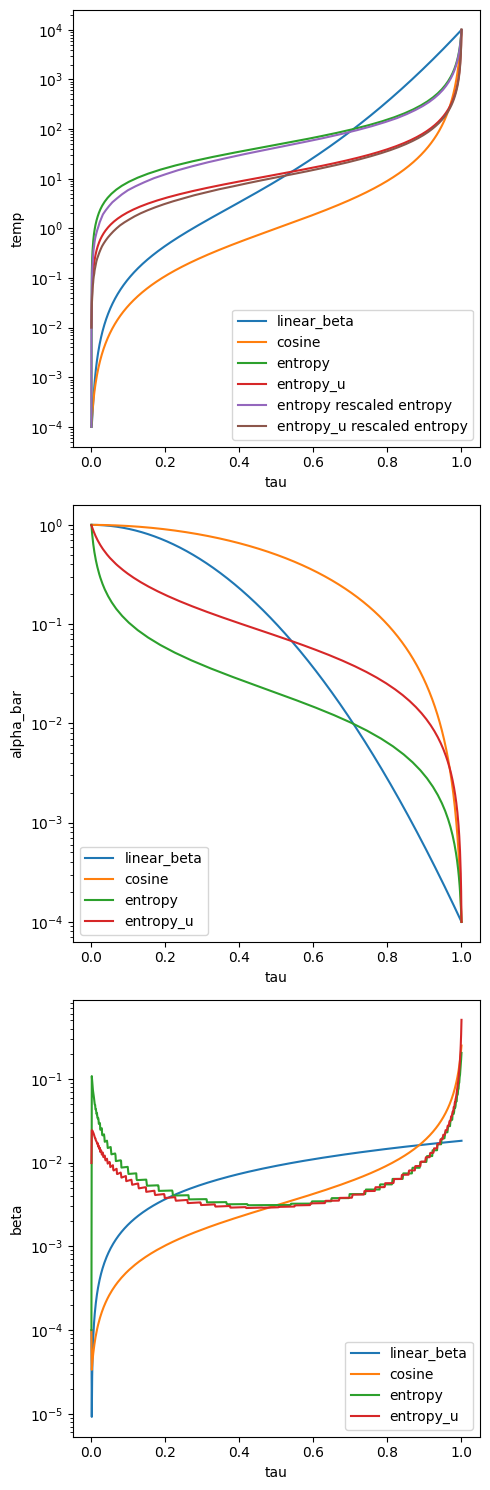

In [5]:
from config import load_config
from diffusion import get_schedule, DynamicCoeffs
import matplotlib.pyplot as plt
from torch import linspace
import numpy as np


config = load_config()
config.data.dataset_name = "cifar10"
tau = linspace(0, 1, 1000)
coeffs_dict: dict[str, DynamicCoeffs] = {}
for noise_schedule in [
    "linear_beta",
    "cosine",
    "entropy",
    "entropy_u",
]:
    config.diffusion.noise_schedule = noise_schedule
    coeffs_dict[noise_schedule] = DynamicCoeffs(get_schedule(config)(tau))

coeff_names = ["temp", "alpha_bar", "beta"]


plt.figure(figsize=(5, len(coeff_names) * 5))

for i, coeff_name in enumerate(coeff_names, 1):
    plt.subplot(len(coeff_names), 1, i)
    for name, coeffs in coeffs_dict.items():
        plt.plot(tau, getattr(coeffs, coeff_name), label=name)

    if coeff_name == "temp":
        for noise_schedule in ["entropy", "entropy_u"]:
            config.diffusion.noise_schedule = noise_schedule
            stats = np.load(config.schedule_stats_path)
            temp = stats["temp"]
            tau_ = stats["log_Z"] + stats["U"] / temp
            tau_ -= tau_.min()
            tau_ /= tau_.max()
            plt.plot(tau_, temp, label=f"{noise_schedule} rescaled entropy")

    plt.yscale("log")
    plt.xlabel("tau")
    plt.ylabel(coeff_name)
    plt.legend()

plt.tight_layout()
plt.show()

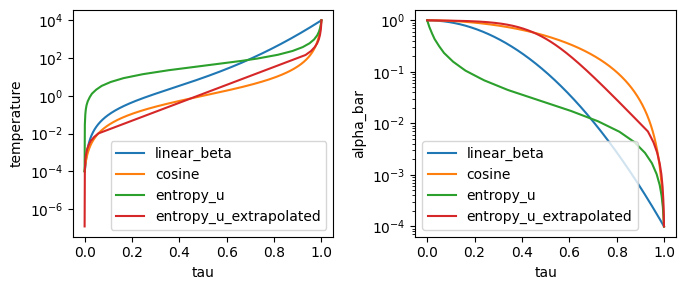

In [1]:
from utils import load_config
from diffusion.diffusion_dynamic import DiffusionDynamic
import matplotlib.pyplot as plt
from torch import linspace
import numpy as np


config = load_config()
config.data.dataset_name = "cifar10"
tau = linspace(0, 1, 1000)
dynamic_dict: dict[str, DiffusionDynamic] = {}
for noise_schedule in [
    "linear_beta",
    "cosine",
    # "entropy",
    "entropy_u",
    "entropy_u_extrapolated"
]:
    config.diffusion.noise_schedule_type = noise_schedule
    dynamic_dict[noise_schedule] = DiffusionDynamic(config)

plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)
for name, dynamic in dynamic_dict.items():
    plt.plot(tau, dynamic.get_log_temp(tau).flatten().exp(), label=name)
plt.yscale("log")
plt.xlabel("tau")
plt.ylabel("temperature")
plt.legend()

plt.subplot(1, 2, 2)
for name, dynamic in dynamic_dict.items():
    plt.plot(tau, dynamic.get_alpha_bar(tau).flatten(), label=name)
plt.yscale("log")
plt.xlabel("tau")
plt.ylabel("alpha_bar")
plt.legend()

plt.tight_layout()
plt.show()

In [2]:
from utils import get_compute_fid, get_data_tensor
import torch
from config import load_config


config = load_config()
config.fid.train = True
config.data.dataset_name = "cifar10"
test_data = get_data_tensor(config, train=False)
compute_fid = get_compute_fid(config)


for temp in torch.logspace(-5, -3, 20):
    print(temp)
    print(compute_fid((test_data + temp ** 0.5 * torch.randn_like(test_data)) / (1 + temp) ** 0.5))

tensor(1.0000e-05)
3.196417218920879
tensor(1.2743e-05)
3.2076141072277498
tensor(1.6238e-05)
3.2308563008292484
tensor(2.0691e-05)


In [3]:
3.15 * 1.25

3.9375

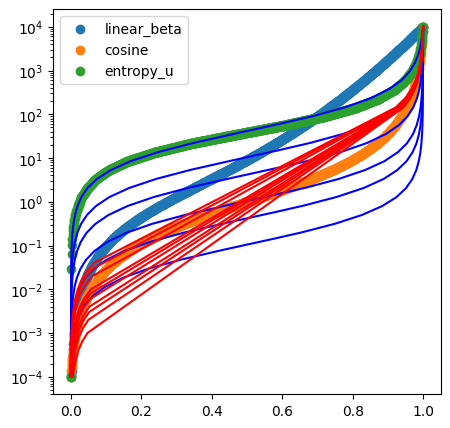

In [14]:
from utils import load_config
import matplotlib.pyplot as plt
from diffusion.diffusion_dynamic import NoiseScheduler
import torch
import numpy as np


plt.figure(figsize=(5, 5))

tau = torch.linspace(0, 1, 1000)
config = load_config()

config.sample.min_temp = 1e-4

config.sample.extrapolation_type = "sigmoid"
for logn_effective in config.fid.varied_parameters["logn_effective"]:
    config.sample.logn_effective = float(logn_effective)
    scheduler = NoiseScheduler.from_config(config, noise_schedule_type="entropy_u_extrapolated")
    temp = scheduler(tau).exp()
    plt.plot(tau, temp, c="blue")

config.sample.extrapolation_type = "linear_middle"
for l_temp in config.fid.varied_parameters["l_temp"]:
    config.sample.l_temp = float(l_temp)
    scheduler = NoiseScheduler.from_config(config, noise_schedule_type="entropy_u_extrapolated")
    temp = scheduler(tau).exp()
    # plt.plot(tau, temp, c=get_heatmap_color(np.log(float(logn_effective)) / np.log(4e6)))
    plt.plot(tau, temp, c="red")

for noise_schedule_type in ["linear_beta", "cosine", "entropy_u"]:
    scheduler = NoiseScheduler.from_config(config, noise_schedule_type=noise_schedule_type)
    temp = scheduler(tau).exp()
    plt.scatter(tau, temp, label = noise_schedule_type)

plt.yscale("log")
plt.legend()
plt.show()

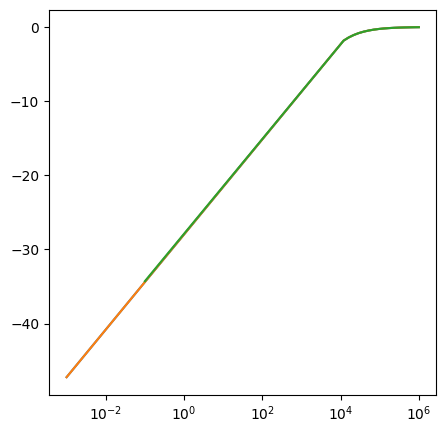

In [2]:
from utils import load_config
import matplotlib.pyplot as plt
from diffusion.diffusion_dynamic import NoiseScheduler
import torch
import numpy as np


plt.figure(figsize=(5, 5))

tau = torch.linspace(0, 1, 1000)
config = load_config()

config.sample.min_temp = 1e-4

# config.sample.extrapolation_type = "sigmoid"
# for logn_effective in config.fid.varied_parameters["logn_effective"]:
#     config.sample.logn_effective = float(logn_effective)
#     scheduler = NoiseScheduler.from_config(config, noise_schedule_type="entropy_u_extrapolated")
#     temp = scheduler(tau).exp()
#     plt.plot(tau, temp, c="blue")

# config.sample.extrapolation_type = "linear_middle"
for min_temp in [1e-3, 1e-3, 1e-1]:
    config.sample.min_temp = float(min_temp)
    scheduler = NoiseScheduler.from_config(config, noise_schedule_type="entropy_u_extrapolated")
    # temp = scheduler(tau).exp()
    # plt.plot(tau, temp, c=get_heatmap_color(np.log(float(logn_effective)) / np.log(4e6)))
    # plt.plot(tau, temp, c="red")

plt.xscale("log")
plt.show()

# for noise_schedule_type in ["linear_beta", "cosine", "entropy_u"]:
#     scheduler = NoiseScheduler.from_config(config, noise_schedule_type=noise_schedule_type)
#     temp = scheduler(tau).exp()
#     plt.scatter(tau, temp, label = noise_schedule_type)

# plt.yscale("log")
# plt.legend()
# plt.show()

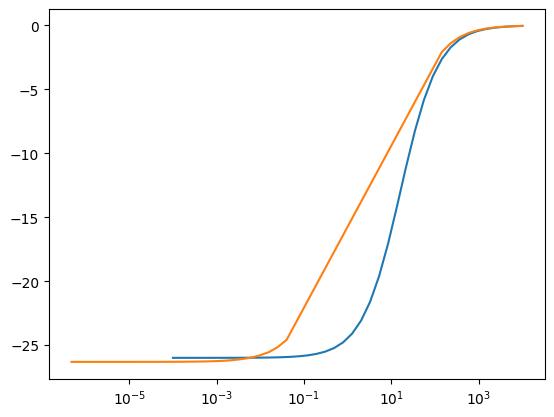

In [7]:
from utils import load_config
import matplotlib.pyplot as plt
from diffusion.diffusion_dynamic import NoiseScheduler
import torch
import numpy as np


# plt.figure(figsize=(5, 5))

tau = torch.linspace(0, 1, 1000)
config = load_config()

config.sample.min_temp = 1e-4

config.sample.extrapolation_type = "sigmoid"
for logn_effective in config.fid.varied_parameters["logn_effective"]:
    # config.sample.logn_effective = float(logn_effective)
    config.sample.logn_effective = 26
    scheduler = NoiseScheduler.from_config(config, noise_schedule_type="entropy_u_extrapolated")
    temp = scheduler(tau).exp()
    # plt.plot(tau, temp, c="blue")
    break

# plt.show()

config.sample.extrapolation_type = "linear_middle"
for l_temp in config.fid.varied_parameters["l_temp"]:
    config.sample.l_temp = float(l_temp)
    scheduler = NoiseScheduler.from_config(config, noise_schedule_type="entropy_u_extrapolated")
    temp = scheduler(tau).exp()
    # plt.plot(tau, temp, c=get_heatmap_color(np.log(float(logn_effective)) / np.log(4e6)))
    # plt.plot(tau, temp, c="red")
    break

# plt.show()

for noise_schedule_type in ["linear_beta", "cosine", "entropy_u"]:
    scheduler = NoiseScheduler.from_config(config, noise_schedule_type=noise_schedule_type)
    temp = scheduler(tau).exp()
    # plt.scatter(tau, temp, label = noise_schedule_type)

# plt.yscale("log")
# plt.legend()
# plt.show()

In [11]:
import pandas as pd


baselines = pd.read_csv("results/cifar10_train_fid_baselines.csv")
baselines.sort_values("fid")

,Unnamed: 0,fid,sample_noise_schedule_type
1,1,19.099934,entropy_u_extrapolated
2,2,23.060425,linear_beta
3,3,23.929214,cosine
4,4,24.635822,original
0,0,100.095840,entropy_u


In [10]:
sigmoid = pd.read_csv("results/cifar10_train_fid_sigmoid.csv")
sigmoid.sort_values("fid")

,Unnamed: 0,fid,logn_effective,min_temp
4,4,29.466743,100.0,0.0100
2,2,35.845654,40.0,0.0100
6,6,37.058826,400.0,0.0100
5,5,39.092663,100.0,0.0001
7,7,39.630440,400.0,0.0001
3,3,51.791809,40.0,0.0001
8,8,52.562866,1000.0,0.0100
9,9,53.689804,1000.0,0.0001
0,0,66.910851,10.0,0.0100
1,1,96.254150,10.0,0.0001


In [12]:
linear_middle = pd.read_csv("results/cifar10_train_fid.csv")
linear_middle.sort_values("fid")

,Unnamed: 0,fid,l_temp,min_temp
18,18,18.926344,0.010,0.0004
14,14,19.006439,0.020,0.0001
12,12,19.070099,0.020,0.0010
19,19,19.187563,0.010,0.0001
15,15,19.257496,0.010,0.0100
8,8,19.259903,0.030,0.0004
20,20,19.270756,0.008,0.0100
16,16,19.320549,0.010,0.0040
13,13,19.333878,0.020,0.0004
5,5,19.364637,0.030,0.0100
